# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Загрузка и подключение библиотек

In [107]:
!pip install scikit_learn==1.5.0 -q
!pip install phik -q

In [204]:
import pandas as pd
import phik
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from scipy import stats as st

Загрузка датафреймов

In [109]:
try:
    geo_data_0=pd.read_csv('/datasets/geo_data_0.csv')
except FileNotFoundError:
    geo_data_0=pd.read_csv('./geo_data_0.csv')

In [110]:
try:
    geo_data_1=pd.read_csv('/datasets/geo_data_1.csv')
except FileNotFoundError:
    geo_data_1=pd.read_csv('./geo_data_1.csv')

In [111]:
try:
    geo_data_2=pd.read_csv('/datasets/geo_data_2.csv')
except FileNotFoundError:
    geo_data_2=pd.read_csv('./geo_data_2.csv')

### geo_data_0

Просмотр первичной информации

In [112]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Просмотр первых строк

In [113]:
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Вывод количеста дубликатов

In [114]:
geo_data_0.duplicated().sum()

0

### geo_data_1

Просмотр первичной информации

In [115]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Просмотр первых строк

In [116]:
geo_data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Вывод количеста дубликатов

In [117]:
geo_data_1.duplicated().sum()

0

### geo_data_2

Просмотр первичной информации

In [118]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Просмотр первых строк

In [119]:
geo_data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Вывод количеста дубликатов

In [120]:
geo_data_2.duplicated().sum()

0

<b>Промежуточный вывод:</b> 

Мы видим, что данные для работы хорошо организованы. В каждом наборе данных ровно 100 000 записей, и нигде нет пустых мест. Более того, мы не нашли повторяющихся записей, то есть дубликатов.

В датасетах присутствуют только числовые характеристики, и отсутствуют любые категориальные переменные.

### Матрицы корреляции

Напишем функцию для построения матриц корреляции и графиков heatmap

In [121]:
def matrix_corr(df):
    phik_matrix=df.drop('id', axis=1).phik_matrix(interval_cols=df.drop('id', axis=1).columns.tolist())
    print(phik_matrix)
    plt.figure(figsize=(10, 7))
    sns.heatmap(phik_matrix, annot=True)

Матрица корреляции для geo_data_0

               f0        f1        f2   product
f0       1.000000  0.762170  0.000000  0.215525
f1       0.762170  1.000000  0.000000  0.253544
f2       0.000000  0.000000  1.000000  0.475901
product  0.215525  0.253544  0.475901  1.000000


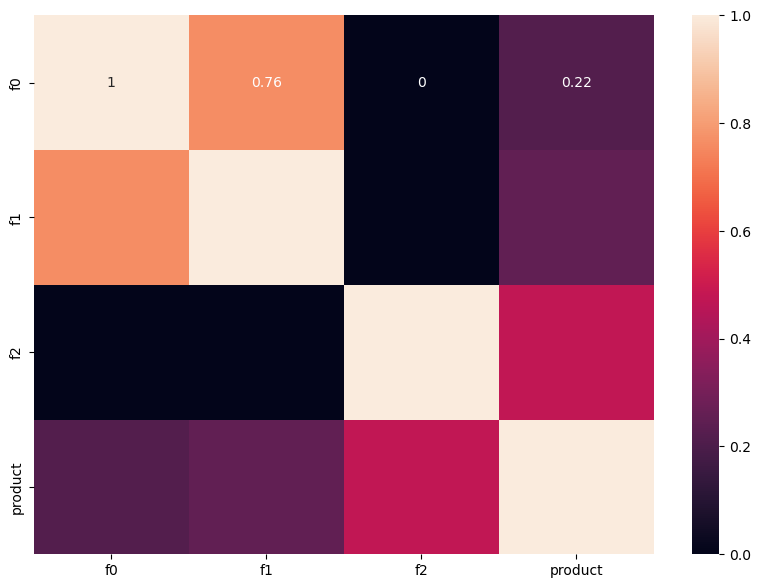

In [122]:
matrix_corr(geo_data_0)

Матрица корреляции для geo_data_1

               f0        f1        f2   product
f0       1.000000  0.196080  0.000000  0.628482
f1       0.196080  1.000000  0.000000  0.185965
f2       0.000000  0.000000  1.000000  0.978936
product  0.628482  0.185965  0.978936  1.000000


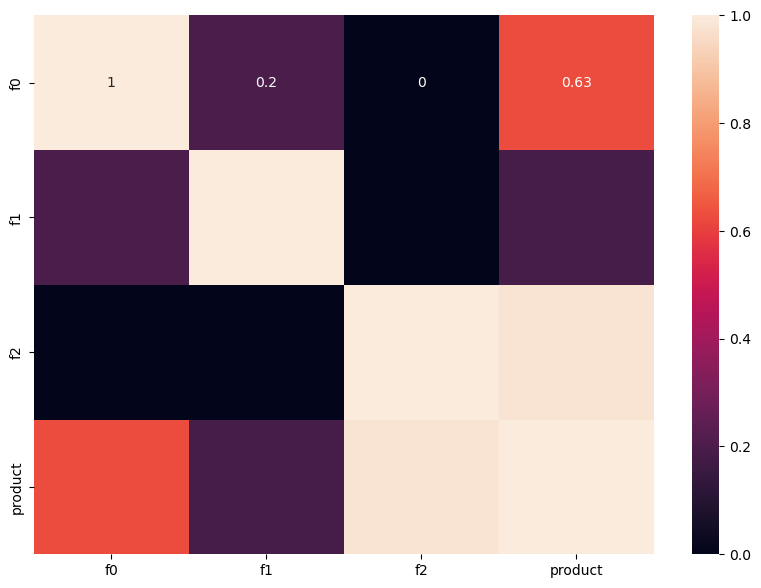

In [123]:
matrix_corr(geo_data_1)

Матрица корреляции для geo_data_2

               f0        f1        f2   product
f0       1.000000  0.000000  0.000000  0.201068
f1       0.000000  1.000000  0.000000  0.221022
f2       0.000000  0.000000  1.000000  0.443287
product  0.201068  0.221022  0.443287  1.000000


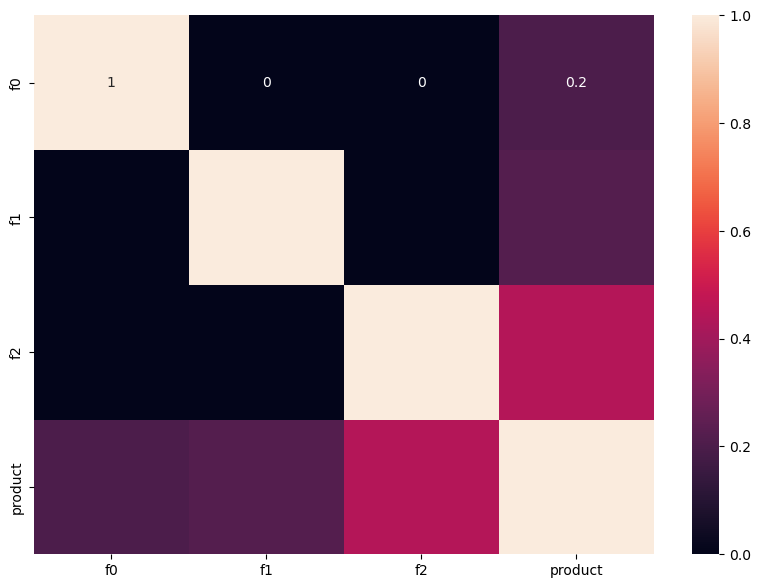

In [124]:
matrix_corr(geo_data_2)

<b>Промежуточный вывод:</b> 

- На первом графике сильная корреляция у f0 и f2 и средний уровень корреляции у product и f2
- На втором графике высокая корреляция у product И f0
- На третьем графике средний уровень корреляции у f2 и product

### Гистограммы

Напишем функцию для построения гистограмм

In [125]:
def plot_hist(df):
    phik_matrix=df.drop('id', axis=1).phik_matrix(interval_cols=df.drop('id', axis=1).columns.tolist())
    df.drop('id', axis=1).hist(figsize=(10, 7), bins=50)
    plt.tight_layout()
    plt.show()

Гистограмма для geo_data_0

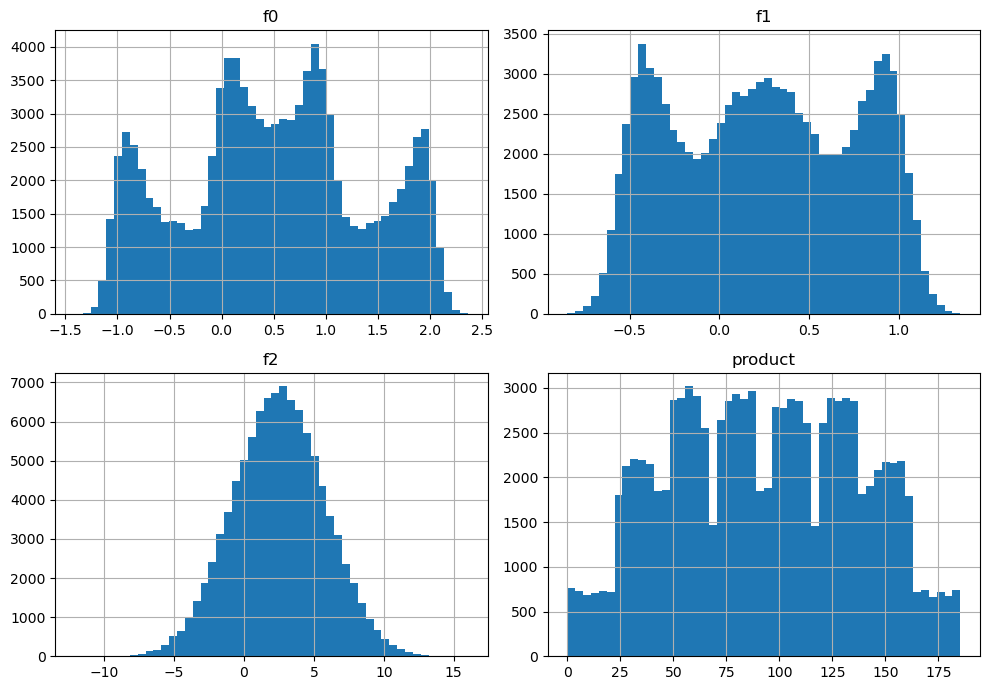

In [126]:
plot_hist(geo_data_0)

Гистограмма для geo_data_1

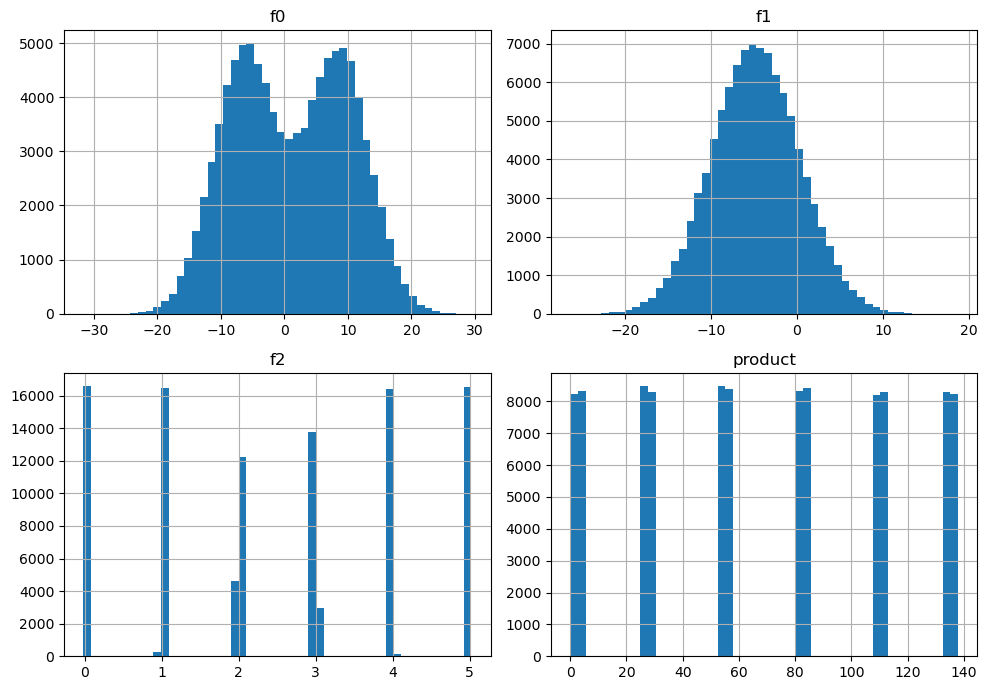

In [127]:
plot_hist(geo_data_1)

Гистограмма для geo_data_2

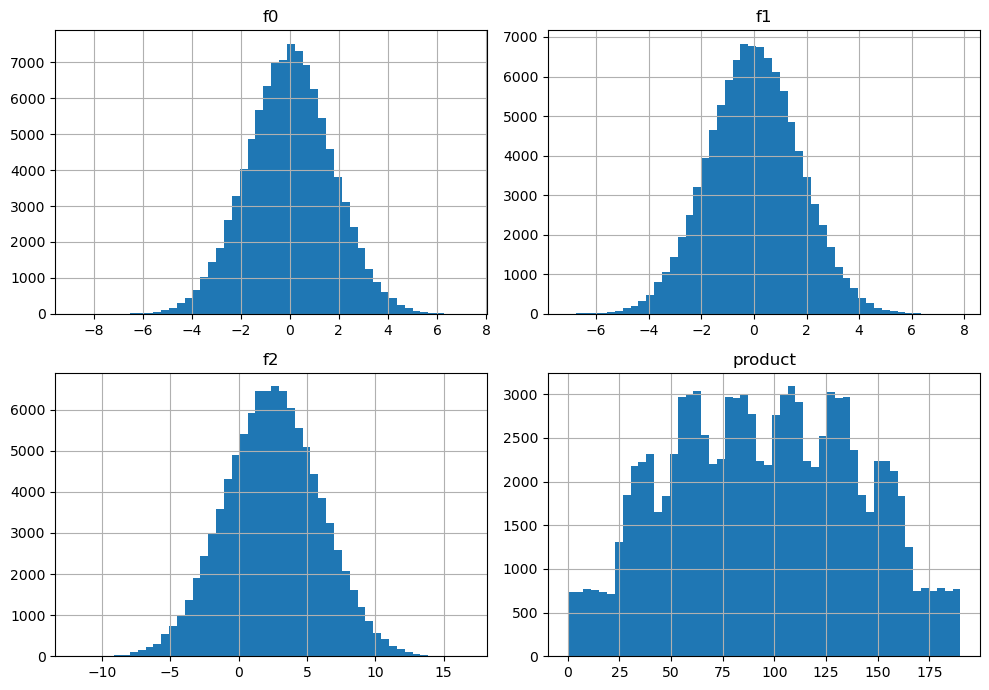

In [128]:
plot_hist(geo_data_2)

<b>Промежуточный вывод:</b>

Анализируя гистограммы, можно заметить, что распределение значений среди признаков значительно варьируется между различными датасетами. В частности, в датасете geo_data_1 заметны резкие отклонения в столбцах f2 и product, которые могут стать препятствием для эффективного обучения моделей.

<b>Вывод:</b> 
- Были установлены и импортированны нужные библиотеки
- Были загружены 3 датафрейма
- Был проведен первычный анализ данных

## Обучение и проверка модели

In [129]:
predict_valid = []
true_target = []
targets_valid = []
predictions_mean = []

In [130]:
RANDOM_STATE=42

In [131]:
def model_learning(df):
    features = df.drop(["product", "id"], axis=1)
    target = df["product"]    
    features_train, features_valid, target_train, target_valid = \
        train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)
    model = LinearRegression()
    model.fit(features_train, target_train)    
    predictions = model.predict(features_valid)
    predict_valid.append(predictions)
    true_target.append(target_train.reset_index(drop=True))
    targets_valid.append(target_valid.reset_index(drop=True))  
    predictions_mean.append(round(predictions.mean(),0))
    print("Предсказанное сырье: {0:.2f}". \
          format(predictions.mean()))
    print("RMSE: {0:.2f}.". \
          format((mean_squared_error(predictions, target_valid))**0.5))

In [132]:
model_learning(geo_data_0)

Предсказанное сырье: 92.40
RMSE: 37.76.


In [134]:
model_learning(geo_data_1)

Предсказанное сырье: 68.71
RMSE: 0.89.


In [135]:
model_learning(geo_data_2)

Предсказанное сырье: 94.77
RMSE: 40.15.


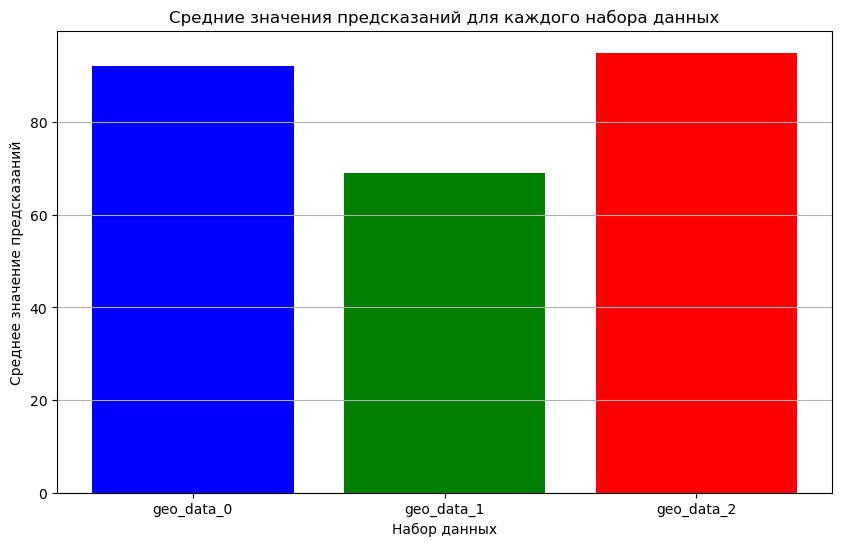

In [136]:
plt.figure(figsize=(10, 6))
plt.bar(['geo_data_0', 'geo_data_1', 'geo_data_2'], predictions_mean, color=['b', 'g', 'r'])
plt.title('Средние значения предсказаний для каждого набора данных')
plt.xlabel('Набор данных')
plt.ylabel('Среднее значение предсказаний')
plt.grid(axis='y')
plt.show()

## Подготовка к расчёту прибыли

При разведке региона исследуюем **500 точек**, из которых с помощью машинного обучения выберем **200** лучших для разработки.<br>
Бюджет на разработку скважин в регионе — **10 млрд рублей.**<br>
При нынешних ценах один баррель сырья приносит  **450 рублей**  дохода. Доход с каждой единицы продукта составляет **450 тыс.<br> рублей**, поскольку объём указан в тысячах баррелей.<br>
После оценки рисков оставим лишь те регионы, в которых вероятность убытков меньше **2.5%**. Среди них выберем регион с наибольшей средней прибылью.<br>

Обьявление переменных

In [137]:
BUDGET = 10000000
INCOME_ONE_PROD = 450 
target_probability_losses = 2.5/100 
product_mean_0 = geo_data_0['product'].mean()
product_mean_1 = geo_data_1['product'].mean()
product_mean_2 = geo_data_2['product'].mean()

Cредний запас сырья в 1-ом регионе млн.баррелей

In [172]:
print(product_mean_0)

92.50000000000001


Cредний запас сырья в 2-ом регионе млн.баррелей

In [173]:
print(product_mean_1)

68.82500000000002


Cредний запас сырья в 3-ем регионе млн.баррелей

In [174]:
print(product_mean_2)

95.00000000000004


Бюджет на одну скважину 50.0 млн.руб

In [176]:
intermediate_variable=(BUDGET/200)
print(intermediate_variable/1000)

50.0


Минимальный объём для безубыточности тыс.баррелей

In [177]:
v_prod=intermediate_variable/INCOME_ONE_PROD
print(v_prod)

111.11111111111111


Функция для расчета 'Отклонение объёма сырья для безубыточности скважины'

In [143]:
def volume_received(df, product_mean, intermediate_variable):
    df['profit']=(df['product']*(INCOME_ONE_PROD)).round(2)
    df['roi']=((df['profit']-intermediate_variable)/intermediate_variable*100)
    print('Отклонение объёма сырья для безубыточности скважины от среднего в регионе', i,':', '\n{:.2%}'.format(product_mean_0/v_prod-1))
    print('Или {:.2f} тыс.баррелей'.format(v_prod-product_mean))
    print(df.head())

In [144]:
i=1
volume_received(geo_data_0, product_mean_0, i)

Отклонение объёма сырья для безубыточности скважины от среднего в регионе 1 : 
-16.75%
Или 18.61 тыс.баррелей
      id        f0        f1        f2     product    profit        roi
0  txEyH  0.705745 -0.497823  1.221170  105.280062  47376.03  4737503.0
1  2acmU  1.334711 -0.340164  4.365080   73.037750  32866.99  3286599.0
2  409Wp  1.022732  0.151990  1.419926   85.265647  38369.54  3836854.0
3  iJLyR -0.032172  0.139033  2.978566  168.620776  75879.35  7587835.0
4  Xdl7t  1.988431  0.155413  4.751769  154.036647  69316.49  6931549.0


In [145]:
i=2
volume_received(geo_data_1, product_mean_1, i)

Отклонение объёма сырья для безубыточности скважины от среднего в регионе 2 : 
-16.75%
Или 42.29 тыс.баррелей
      id         f0         f1        f2     product    profit        roi
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103   1430.60    71430.0
1  62mP7  14.272088  -3.475083  0.999183   26.953261  12128.97   606348.5
2  vyE1P   6.263187  -5.948386  5.001160  134.766305  60644.84  3032142.0
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408  62075.43  3103671.5
4  AHL4O  12.702195  -8.147433  5.004363  134.766305  60644.84  3032142.0


In [146]:
i=3
volume_received(geo_data_2, product_mean_2, i)

Отклонение объёма сырья для безубыточности скважины от среднего в регионе 3 : 
-16.75%
Или 16.11 тыс.баррелей
      id        f0        f1        f2     product    profit           roi
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673  12491.40  4.162800e+05
1  WJtFt  0.262778  0.269839 -2.530187   56.069697  25231.36  8.409453e+05
2  ovLUW  0.194587  0.289035 -5.586433   62.871910  28292.36  9.429787e+05
3  q6cA6  2.236060 -0.553760  0.930038  114.572842  51557.78  1.718493e+06
4  WPMUX -0.515993  1.716266  5.899011  149.600746  67320.34  2.243911e+06


## Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели:

- Выбрать скважины с максимальными значениями предсказаний.
- Просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям.
- Рассчитать прибыль для полученного объёма сырья.

In [169]:
df_result_best_200 = pd.DataFrame(
    columns=['Регион', 'Прибыль (млрд. руб)']
)

predict_200_best = [] 

def calc_profit(target, predictions):
    predictions_sorted = predictions.sort_values(ascending=False)
    target_selected = target[predictions_sorted.index][:200]
    return target_selected.sum() * 450 - BUDGET

i = 0

for region in range(3):
    predictions_sample = pd.Series(predict_valid[region])      
    profit = calc_profit(targets_valid[region], predictions_sample)
    
    df_result_best_200.loc[len(df_result_best_200.index)] = \
        [f"Регион {i+1}", profit/1000000]
    
    i += 1

display(df_result_best_200)

,Регион,Прибыль (млрд. руб)
0,Регион 1,3.359141
1,Регион 2,2.415087
2,Регион 3,2.598572


<b>Вывод:</b>
Все три региона демонстрируют потенциальную прибыльность, о чем свидетельствуют средние значения продукта в каждом из них:

- Регион 1: Среднее значение продукта составляет 3.36 млрд. руб.

- Регион 2: Среднее значение продукта составляет 2.41 млрд. руб.

- Регион 3: Среднее значение продукта составляет 2.6 млрд. руб.

## Расчёт прибыли и рисков 

- Применить технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- Найти среднюю прибыль, 95%-й доверительный интервал и риск убытков.
- Написать выводы: предложить регион для разработки скважин и обоснуйте выбор.

Функция для вычисления прибыли

In [209]:
def profit_for_vp2(predict, target, count):
    probs_sorted = pd.Series(predict).sort_values(ascending=False)
    selected_points = target[probs_sorted.index][:count]
    product = selected_points.sum()
    revenue = product * INCOME_ONE_PROD
    return revenue - BUDGET

Функция для подсчета и построения графиков ожидаемой средней прибыли

In [ ]:
def profit_distribution(target, predict):
    values = []
    count = 0
    state = np.random.RandomState(12345)
    predict_e = pd.Series(predict, index=target.index)
    
    for _ in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        probs_subsample = predict_e[target_subsample.index]
        values.append(profit_for_vp2(probs_subsample, target_subsample, 200))
    
    for i in values:
        if i < 0:
            count += 1
    
    values = pd.Series(values)
    mean = values.mean()
    confidence_interval = st.t.interval(0.95, len(values) - 1, mean, values.sem())
    
    plt.title('Распределение прибыли')
    values.plot(kind="hist", grid=True, figsize=(8, 5))
    plt.xlabel('Прибыль, тыс.руб')
    plt.ylabel('Количество')
    plt.show()
    
    low_95 = values.quantile(0.025)
    high_95 = values.quantile(0.975)
    
    print("Ожидаемая средняя прибыль составляет: {:.2f} млн.руб".format(mean / 1000))
    print('С 95% уверенностью, ожидаемая прибыль в этом регионе будет находиться между: {:.2f} млн.руб и {:.2f} млн.руб'.format((low_95 / 1000), (high_95 / 1000)))
    print("95%-ый доверительный интервал для прибыли: от {:.2f} млн.руб до {:.2f} млн.руб".format((confidence_interval[0] / 1000), (confidence_interval[1] / 1000)))
    print('Вероятность понести убытки в данном регионе оценивается в {:.1%}'.format(count / 1000))

График для 1-го региона

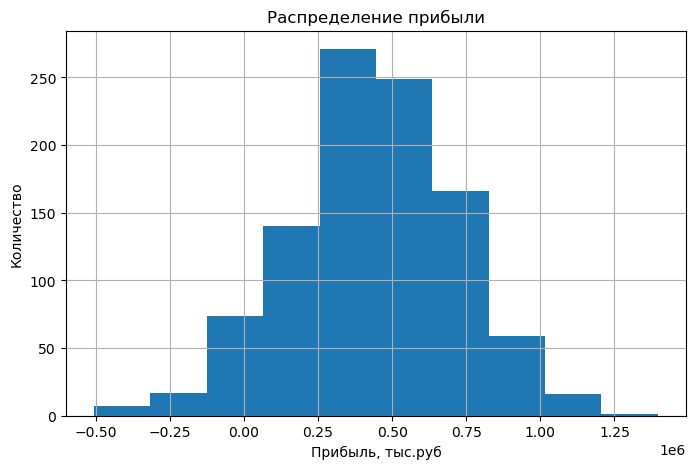

Ожидаемая средняя прибыль составляет: 435.93 млн.руб
С 95% уверенностью, ожидаемая прибыль в этом регионе будет находиться между: -116.23 млн.руб и 966.50 млн.руб
95%-ый доверительный интервал для прибыли: от 418.76 млн.руб до 453.11 млн.руб
Вероятность понести убытки в данном регионе оценивается в 6.1%


In [208]:
profit_distribution(targets_valid[0], predict_valid[0])

График для 2-го региона

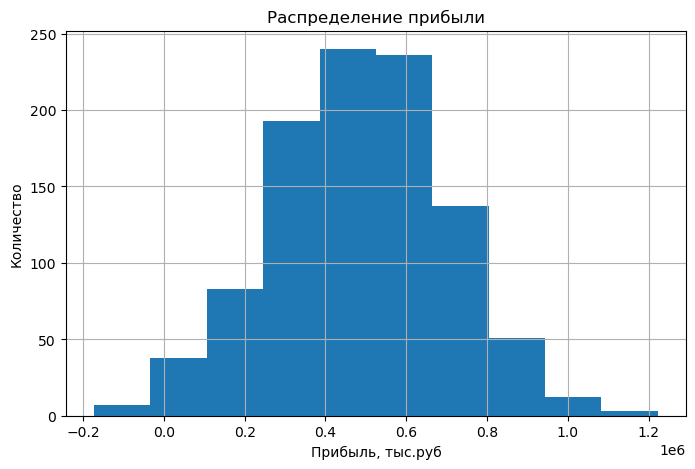

Ожидаемая средняя прибыль составляет: 489.66 млн.руб
С 95% уверенностью, ожидаемая прибыль в этом регионе будет находиться между: 55.12 млн.руб и 905.76 млн.руб
95%-ый доверительный интервал для прибыли: от 476.23 млн.руб до 503.09 млн.руб
Вероятность понести убытки в данном регионе оценивается в 1.1%


In [212]:
profit_distribution(targets_valid[1], predict_valid[1])

График для 3-го региона

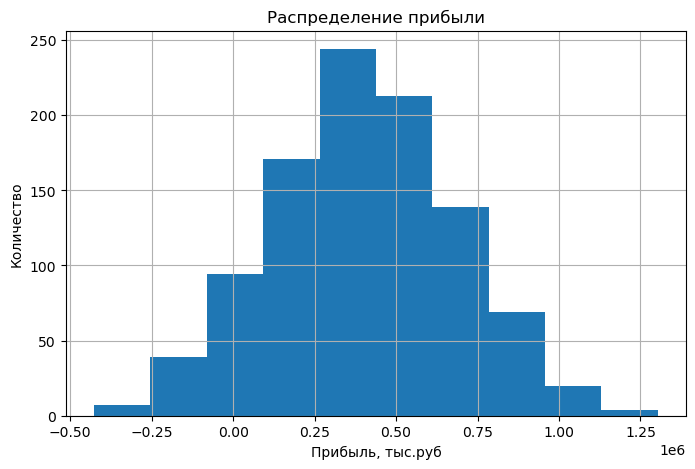

Ожидаемая средняя прибыль составляет: 403.69 млн.руб
С 95% уверенностью, ожидаемая прибыль в этом регионе будет находиться между: -153.12 млн.руб и 952.89 млн.руб
95%-ый доверительный интервал для прибыли: от 386.21 млн.руб до 421.17 млн.руб
Вероятность понести убытки в данном регионе оценивается в 7.1%


In [213]:
profit_distribution(targets_valid[2], predict_valid[2])

Гистограмма для средней прибыли трёх представленных регионов

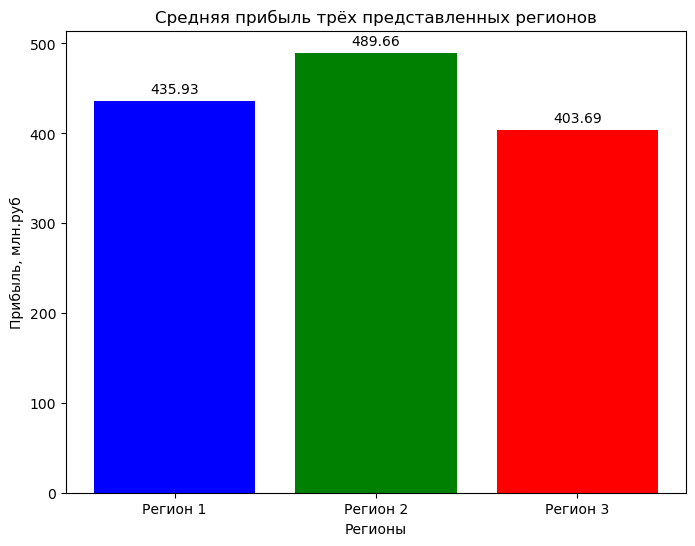

In [214]:
regions = ['Регион 1', 'Регион 2', 'Регион 3']
profits = [435.93, 489.66, 403.69] 

plt.figure(figsize=(8, 6))
plt.bar(regions, profits, color=['blue', 'green', 'red'])

plt.title('Средняя прибыль трёх представленных регионов')
plt.xlabel('Регионы')
plt.ylabel('Прибыль, млн.руб')

# Добавление значений над столбцами
for i, v in enumerate(profits):
    plt.text(i, v + 5, f'{v:.2f}', ha='center', va='bottom')

plt.show()

<b>Вывод:</b>
Второй регион оказался наиболее прибыльным с прогнозируемой средней прибылью в 489.66 млн.рублей. В отличие от других регионов, где вероятность убытков превышает 2.5%, регион 2 демонстрирует уверенную доходность с 95%-м доверительным интервалом, не включающим отрицательные значения.

## Общий вывод

После предобработки данных и проведения первичного анализа, была обучена модель, которая показала, что средний запас сырья во всех регионах ниже точки безубыточности в 111 тыс. баррелей. Это свидетельствует о нерентабельности разработки всех скважин сразу. Однако, при тщательном анализе и выборе 200 наиболее перспективных скважин, регион №2 выделяется как наименее рискованный с точки зрения возможных убытков. Таким образом, стратегия фокусировки на выборочной разработке в регионе №2 представляется наиболее целесообразной для минимизации рисков и оптимизации финансовых результатов.